In [2]:
%%capture
!pip install transformers

In [3]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

from sklearn.utils import shuffle

/home/tfsservices/miniconda3/envs/nlp_test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
datapath = f'intents.csv'
# datapath = f'intents-without-none.csv'
df = pd.read_csv(datapath)
df.head()


,intent,utterance
0,Accept,$ 950k - $ 1.3 m is okay.
1,Accept,$1.2m is a pretty good offer.
2,Accept,$7k for the system including the pump works fo...
3,Accept,"€12,000 is good."
4,Accept,"1,550,000.00 usd is approved."


In [5]:
labels = {
    'Accept':0,
    'AskForEquipmentInstallation':1,
    'AskForInterest':2,
    'AskForPrice':3,
    'AskIfBuy':4,
    'AskIfHaveEquipment':5,
    'AskIfSell':6,
    'Decline':7,
    'DeclinePrice':8,
    'DeclineToBuy':9,
    'DeclineToSell':10,
    'DoNotHaveEquipment':11,
    'HaveDeinstalledEquipment':12,
    'HaveEquipment':13,
    'HaveInstalledEquipment':14,
    'None':15,
    'OfferPrice':16,
    'WantDeal':17,
    'WantToBuy':18,
    'WantToSell':19
}

ids_to_labels = {v: k for v, k in enumerate(labels)}

In [6]:
df = shuffle(df)
df.head()

,intent,utterance
6169,WantToBuy,would love to buy this.
6272,WantToSell,is releasing hitachi s-3200n.
3581,None,i spoke with him finally yesterday.
2055,DoNotHaveEquipment,no board handlers.
3174,None,he has people in japan.


<Axes: xlabel='intent'>

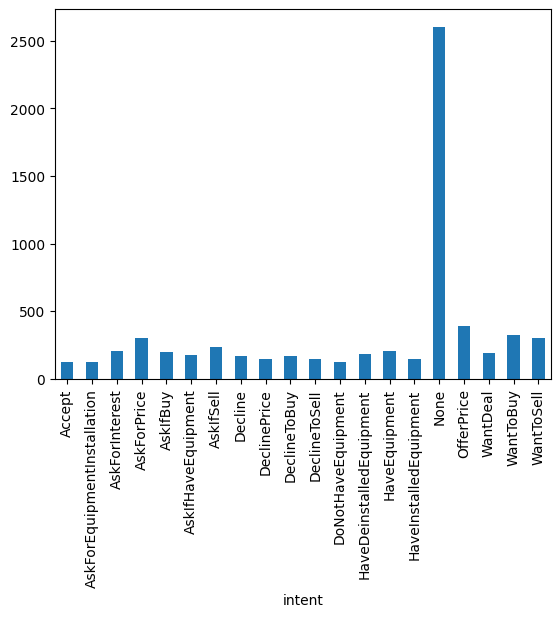

In [7]:
df.groupby(['intent']).size().plot.bar()

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')


In [9]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['intent']]
        self.texts = [
            tokenizer(text, 
                      padding='max_length', max_length = 512, truncation=True,
                      return_tensors="pt") for text in df['utterance']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [10]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        # self.linear = nn.Linear(768, 19)
        self.linear = nn.Linear(768, len(labels))
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [11]:
def train(model, train_data, val_data, learning_rate, epochs, batch_size):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')


In [12]:
def evaluate(model, test_data, batch_size:int):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

In [13]:
np.random.seed(112)
# df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), [int(.8*len(df)), int(.9*len(df))])
# df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), [int(.98*len(df)), int(.99*len(df))])
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), [int(.98*len(df)), int(.99*len(df))])

print(len(df_train),len(df_val), len(df_test))

6342 65 65


In [14]:
EPOCHS = 10
LR = 1e-6
BATCH_SIZE = 2

model = BertClassifier()
train(model, df_train, df_val, LR, EPOCHS, BATCH_SIZE)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 3171/3171 [02:57<00:00, 17.87it/s]


Epochs: 1 | Train Loss:  1.215 | Train Accuracy:  0.340 | Val Loss:  1.118 | Val Accuracy:  0.431


100%|██████████| 3171/3171 [02:57<00:00, 17.84it/s]


Epochs: 2 | Train Loss:  0.953 | Train Accuracy:  0.491 | Val Loss:  1.012 | Val Accuracy:  0.446


100%|██████████| 3171/3171 [02:57<00:00, 17.88it/s]


Epochs: 3 | Train Loss:  0.767 | Train Accuracy:  0.598 | Val Loss:  0.806 | Val Accuracy:  0.600


100%|██████████| 3171/3171 [02:57<00:00, 17.90it/s]


Epochs: 4 | Train Loss:  0.594 | Train Accuracy:  0.718 | Val Loss:  0.663 | Val Accuracy:  0.723


100%|██████████| 3171/3171 [02:57<00:00, 17.89it/s]


Epochs: 5 | Train Loss:  0.446 | Train Accuracy:  0.823 | Val Loss:  0.548 | Val Accuracy:  0.769


100%|██████████| 3171/3171 [02:57<00:00, 17.89it/s]


Epochs: 6 | Train Loss:  0.325 | Train Accuracy:  0.886 | Val Loss:  0.447 | Val Accuracy:  0.831


100%|██████████| 3171/3171 [02:57<00:00, 17.89it/s]


Epochs: 7 | Train Loss:  0.233 | Train Accuracy:  0.928 | Val Loss:  0.342 | Val Accuracy:  0.862


100%|██████████| 3171/3171 [02:57<00:00, 17.91it/s]


Epochs: 8 | Train Loss:  0.157 | Train Accuracy:  0.960 | Val Loss:  0.363 | Val Accuracy:  0.831


  8%|▊         | 239/3171 [00:13<02:44, 17.85it/s]


KeyboardInterrupt: 

In [15]:
evaluate(model, df_test, BATCH_SIZE)

Test Accuracy:  0.846


In [16]:
import json

In [17]:
def evaluate_one_text(model, sentence):

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    text = tokenizer(sentence, padding='max_length', max_length = 512, truncation=True, return_tensors="pt")

    mask = text['attention_mask'].to(device)
    input_id = text['input_ids'].to(device)

    output = model(input_id, mask)

    with torch.no_grad():
        # print(output[0])

        probs = {ids_to_labels[i]:prob for i, prob in enumerate(torch.softmax(output[0], dim=-1).cpu().numpy())}
        sorted_probs = {k: v for k, v in sorted(probs.items(), key=lambda item: item[1], reverse=True)}
        print(sorted_probs)

        # label_id = output.argmax(dim=1)[0].item()
        # label = ids_to_labels[label_id]
        # print(label)

In [18]:
evaluate_one_text(model, "What is the price for this amat/applied materials unit.")

{'AskForPrice': 0.87793034, 'OfferPrice': 0.023116995, 'HaveInstalledEquipment': 0.0084340125, 'Accept': 0.007294896, 'None': 0.0068926928, 'AskIfSell': 0.006358399, 'WantDeal': 0.0060259937, 'DeclinePrice': 0.005961386, 'WantToSell': 0.00544438, 'AskIfBuy': 0.0053272154, 'AskForInterest': 0.004881418, 'DoNotHaveEquipment': 0.0048562954, 'AskForEquipmentInstallation': 0.004684488, 'AskIfHaveEquipment': 0.004684488, 'Decline': 0.004684488, 'DeclineToBuy': 0.004684488, 'DeclineToSell': 0.004684488, 'HaveDeinstalledEquipment': 0.004684488, 'HaveEquipment': 0.004684488, 'WantToBuy': 0.004684488}


In [19]:
evaluate_one_text(model, "Do you have this equipment?")

{'AskIfHaveEquipment': 0.7155939, 'AskIfBuy': 0.035149023, 'AskForEquipmentInstallation': 0.033871528, 'AskForInterest': 0.026417904, 'DoNotHaveEquipment': 0.02605449, 'AskIfSell': 0.021407254, 'HaveEquipment': 0.013339684, 'Decline': 0.012962977, 'None': 0.012009604, 'HaveDeinstalledEquipment': 0.011084783, 'AskForPrice': 0.009670952, 'DeclinePrice': 0.00965968, 'Accept': 0.009097273, 'DeclineToBuy': 0.009097273, 'DeclineToSell': 0.009097273, 'HaveInstalledEquipment': 0.009097273, 'OfferPrice': 0.009097273, 'WantDeal': 0.009097273, 'WantToBuy': 0.009097273, 'WantToSell': 0.009097273}


In [20]:
evaluate_one_text(model, "I am going to buy it for my company.")

{'WantToBuy': 0.77064633, 'WantToSell': 0.046400234, 'WantDeal': 0.027831074, 'DeclineToBuy': 0.019905794, 'DeclinePrice': 0.013577436, 'HaveInstalledEquipment': 0.0113623245, 'Accept': 0.0094270315, 'AskIfBuy': 0.009304696, 'AskIfSell': 0.008376279, 'OfferPrice': 0.007767368, 'AskForEquipmentInstallation': 0.0075401287, 'AskForInterest': 0.0075401287, 'AskForPrice': 0.0075401287, 'AskIfHaveEquipment': 0.0075401287, 'Decline': 0.0075401287, 'DeclineToSell': 0.0075401287, 'DoNotHaveEquipment': 0.0075401287, 'HaveDeinstalledEquipment': 0.0075401287, 'HaveEquipment': 0.0075401287, 'None': 0.0075401287}


In [21]:
evaluate_one_text(model, "What is the whether today?")

{'None': 0.97736883, 'AskForInterest': 0.0034101568, 'AskForPrice': 0.0022474593, 'AskIfHaveEquipment': 0.0018970915, 'Accept': 0.0016547564, 'WantDeal': 0.0012490745, 'AskForEquipmentInstallation': 0.001088749, 'Decline': 0.0010231821, 'AskIfBuy': 0.00086614804, 'AskIfSell': 0.000835869, 'DeclinePrice': 0.000835869, 'DeclineToBuy': 0.000835869, 'DeclineToSell': 0.000835869, 'DoNotHaveEquipment': 0.000835869, 'HaveDeinstalledEquipment': 0.000835869, 'HaveEquipment': 0.000835869, 'HaveInstalledEquipment': 0.000835869, 'OfferPrice': 0.000835869, 'WantToBuy': 0.000835869, 'WantToSell': 0.000835869}


In [23]:
evaluate_one_text(model, "price?")

{'AskForPrice': 0.928882, 'AskForInterest': 0.019473763, 'AskIfBuy': 0.0051597855, 'Accept': 0.004756478, 'DeclinePrice': 0.004688959, 'AskIfSell': 0.0041833585, 'None': 0.0033416874, 'DoNotHaveEquipment': 0.0032726936, 'HaveInstalledEquipment': 0.0023867472, 'HaveEquipment': 0.00225272, 'AskForEquipmentInstallation': 0.002160187, 'AskIfHaveEquipment': 0.002160187, 'Decline': 0.002160187, 'DeclineToBuy': 0.002160187, 'DeclineToSell': 0.002160187, 'HaveDeinstalledEquipment': 0.002160187, 'OfferPrice': 0.002160187, 'WantDeal': 0.002160187, 'WantToBuy': 0.002160187, 'WantToSell': 0.002160187}


In [24]:
evaluate_one_text(model, "good enough?")

{'None': 0.46456534, 'AskForInterest': 0.3589044, 'WantDeal': 0.02085898, 'Accept': 0.016223133, 'AskForPrice': 0.014868883, 'AskIfBuy': 0.014588483, 'AskForEquipmentInstallation': 0.011593876, 'AskIfHaveEquipment': 0.0115301665, 'HaveEquipment': 0.008184502, 'AskIfSell': 0.0075092996, 'WantToSell': 0.007505899, 'Decline': 0.0070741177, 'DeclinePrice': 0.0070741177, 'DeclineToBuy': 0.0070741177, 'DeclineToSell': 0.0070741177, 'DoNotHaveEquipment': 0.0070741177, 'HaveDeinstalledEquipment': 0.0070741177, 'HaveInstalledEquipment': 0.0070741177, 'OfferPrice': 0.0070741177, 'WantToBuy': 0.0070741177}


In [25]:
evaluate_one_text(model, "kla tencor?")

{'AskIfSell': 0.21709855, 'AskForEquipmentInstallation': 0.21300681, 'AskIfHaveEquipment': 0.13903241, 'AskForInterest': 0.101318724, 'AskIfBuy': 0.06915638, 'AskForPrice': 0.048866913, 'OfferPrice': 0.030460024, 'HaveDeinstalledEquipment': 0.021107292, 'WantToSell': 0.0165179, 'Accept': 0.013039547, 'Decline': 0.013039547, 'DeclinePrice': 0.013039547, 'DeclineToBuy': 0.013039547, 'DeclineToSell': 0.013039547, 'DoNotHaveEquipment': 0.013039547, 'HaveEquipment': 0.013039547, 'HaveInstalledEquipment': 0.013039547, 'None': 0.013039547, 'WantDeal': 0.013039547, 'WantToBuy': 0.013039547}


In [26]:
evaluate_one_text(model, "kla tencor.")

{'WantToSell': 0.3074497, 'HaveEquipment': 0.14781605, 'WantToBuy': 0.073141046, 'DeclineToSell': 0.058000557, 'OfferPrice': 0.04403818, 'DeclinePrice': 0.04151325, 'Accept': 0.035329748, 'AskIfSell': 0.03185199, 'DoNotHaveEquipment': 0.031572387, 'None': 0.03013954, 'HaveInstalledEquipment': 0.02894686, 'AskForEquipmentInstallation': 0.018911198, 'AskForInterest': 0.018911198, 'AskForPrice': 0.018911198, 'AskIfBuy': 0.018911198, 'AskIfHaveEquipment': 0.018911198, 'Decline': 0.018911198, 'DeclineToBuy': 0.018911198, 'HaveDeinstalledEquipment': 0.018911198, 'WantDeal': 0.018911198}


In [27]:
evaluate_one_text(model, "do it?")

{'None': 0.9052222, 'AskForInterest': 0.0313498, 'Decline': 0.006507385, 'AskForEquipmentInstallation': 0.0063748485, 'AskIfHaveEquipment': 0.0056049842, 'WantDeal': 0.005475396, 'AskForPrice': 0.004673873, 'DeclineToBuy': 0.0038081172, 'Accept': 0.0025819542, 'AskIfBuy': 0.0025819542, 'AskIfSell': 0.0025819542, 'DeclinePrice': 0.0025819542, 'DeclineToSell': 0.0025819542, 'DoNotHaveEquipment': 0.0025819542, 'HaveDeinstalledEquipment': 0.0025819542, 'HaveEquipment': 0.0025819542, 'HaveInstalledEquipment': 0.0025819542, 'OfferPrice': 0.0025819542, 'WantToBuy': 0.0025819542, 'WantToSell': 0.0025819542}


In [28]:
evaluate_one_text(model, "is it still deinstalled?")

{'AskForEquipmentInstallation': 0.7826641, 'AskIfSell': 0.03436578, 'AskIfHaveEquipment': 0.024888279, 'DeclineToSell': 0.014696896, 'AskIfBuy': 0.013911255, 'HaveDeinstalledEquipment': 0.013652937, 'AskForInterest': 0.00913006, 'OfferPrice': 0.009072743, 'HaveEquipment': 0.008787502, 'None': 0.008513548, 'Accept': 0.008031688, 'AskForPrice': 0.008031688, 'Decline': 0.008031688, 'DeclinePrice': 0.008031688, 'DeclineToBuy': 0.008031688, 'DoNotHaveEquipment': 0.008031688, 'HaveInstalledEquipment': 0.008031688, 'WantDeal': 0.008031688, 'WantToBuy': 0.008031688, 'WantToSell': 0.008031688}


In [29]:
evaluate_one_text(model, "we are going to remove this unit from production next week.")

{'HaveDeinstalledEquipment': 0.3117689, 'HaveInstalledEquipment': 0.09889904, 'HaveEquipment': 0.08805725, 'DeclineToSell': 0.0652029, 'WantToSell': 0.05262022, 'DeclineToBuy': 0.046810664, 'DoNotHaveEquipment': 0.038615946, 'WantToBuy': 0.029944621, 'OfferPrice': 0.02820212, 'None': 0.024586426, 'Accept': 0.0215292, 'AskForEquipmentInstallation': 0.0215292, 'AskForInterest': 0.0215292, 'AskForPrice': 0.0215292, 'AskIfBuy': 0.0215292, 'AskIfHaveEquipment': 0.0215292, 'AskIfSell': 0.0215292, 'Decline': 0.0215292, 'DeclinePrice': 0.0215292, 'WantDeal': 0.0215292}


In [30]:
evaluate_one_text(model, "next week.")

{'None': 0.9880149, 'WantDeal': 0.0016548098, 'Decline': 0.0015076428, 'Accept': 0.0013216882, 'AskForInterest': 0.0009711102, 'DeclineToBuy': 0.00086875685, 'DoNotHaveEquipment': 0.0006758194, 'AskIfHaveEquipment': 0.0004148142, 'AskForPrice': 0.00040727423, 'AskForEquipmentInstallation': 0.00037848423, 'AskIfBuy': 0.00037848423, 'AskIfSell': 0.00037848423, 'DeclinePrice': 0.00037848423, 'DeclineToSell': 0.00037848423, 'HaveDeinstalledEquipment': 0.00037848423, 'HaveEquipment': 0.00037848423, 'HaveInstalledEquipment': 0.00037848423, 'OfferPrice': 0.00037848423, 'WantToBuy': 0.00037848423, 'WantToSell': 0.00037848423}


In [31]:
evaluate_one_text(model, "we can offer $ 70,000 for the picosun ald in an effort to try to come to an agreement this week .")

{'OfferPrice': 0.8050674, 'DeclinePrice': 0.043331653, 'WantDeal': 0.026522988, 'Accept': 0.021000506, 'WantToBuy': 0.009999576, 'WantToSell': 0.009021949, 'AskIfSell': 0.0085871555, 'AskForPrice': 0.0067168144, 'AskForEquipmentInstallation': 0.006112825, 'Decline': 0.005915982, 'AskForInterest': 0.005772312, 'AskIfBuy': 0.005772312, 'AskIfHaveEquipment': 0.005772312, 'DeclineToBuy': 0.005772312, 'DeclineToSell': 0.005772312, 'DoNotHaveEquipment': 0.005772312, 'HaveDeinstalledEquipment': 0.005772312, 'HaveEquipment': 0.005772312, 'HaveInstalledEquipment': 0.005772312, 'None': 0.005772312}


In [32]:
evaluate_one_text(model, "$ 19k / ea is much beyond my budget even it is new .")

{'DeclinePrice': 0.458032, 'OfferPrice': 0.3456582, 'WantToBuy': 0.020721454, 'DeclineToBuy': 0.01794207, 'HaveDeinstalledEquipment': 0.012771096, 'Accept': 0.011869908, 'DoNotHaveEquipment': 0.01055394, 'AskForEquipmentInstallation': 0.00941933, 'AskForInterest': 0.00941933, 'AskForPrice': 0.00941933, 'AskIfBuy': 0.00941933, 'AskIfHaveEquipment': 0.00941933, 'AskIfSell': 0.00941933, 'Decline': 0.00941933, 'DeclineToSell': 0.00941933, 'HaveEquipment': 0.00941933, 'HaveInstalledEquipment': 0.00941933, 'None': 0.00941933, 'WantDeal': 0.00941933, 'WantToSell': 0.00941933}


In [33]:
evaluate_one_text(model, "my customer budget for candella candela cs20r is 125k based on working condition mike .")

{'OfferPrice': 0.8750039, 'DeclinePrice': 0.03894349, 'Accept': 0.008771657, 'AskForPrice': 0.006042685, 'DoNotHaveEquipment': 0.0058640083, 'HaveInstalledEquipment': 0.0057974737, 'AskIfHaveEquipment': 0.0050947145, 'DeclineToBuy': 0.004916713, 'AskIfSell': 0.0043785004, 'HaveEquipment': 0.0041912934, 'WantToBuy': 0.0041264826, 'AskForEquipmentInstallation': 0.0040965592, 'AskForInterest': 0.0040965592, 'AskIfBuy': 0.0040965592, 'Decline': 0.0040965592, 'DeclineToSell': 0.0040965592, 'HaveDeinstalledEquipment': 0.0040965592, 'None': 0.0040965592, 'WantDeal': 0.0040965592, 'WantToSell': 0.0040965592}


In [34]:
evaluate_one_text(model, "we have a dual turn with gantry loader already .")

{'HaveEquipment': 0.6787693, 'None': 0.06630386, 'WantToBuy': 0.055241153, 'HaveInstalledEquipment': 0.028903458, 'WantToSell': 0.017660655, 'DeclineToBuy': 0.015195864, 'AskIfHaveEquipment': 0.014255892, 'DoNotHaveEquipment': 0.013900739, 'Accept': 0.010701824, 'WantDeal': 0.0103576025, 'AskForEquipmentInstallation': 0.008870973, 'AskForInterest': 0.008870973, 'AskForPrice': 0.008870973, 'AskIfBuy': 0.008870973, 'AskIfSell': 0.008870973, 'Decline': 0.008870973, 'DeclinePrice': 0.008870973, 'DeclineToSell': 0.008870973, 'HaveDeinstalledEquipment': 0.008870973, 'OfferPrice': 0.008870973}


In [35]:
evaluate_one_text(model, "but it is still being used not heavily but still being used w / back side alignment .") 

{'None': 0.95788217, 'WantDeal': 0.0064416113, 'Accept': 0.0055891047, 'HaveEquipment': 0.0026963954, 'AskForInterest': 0.0021464126, 'HaveInstalledEquipment': 0.0021373157, 'WantToBuy': 0.0019657295, 'Decline': 0.0017855184, 'AskForPrice': 0.0016936002, 'AskForEquipmentInstallation': 0.0016056527, 'AskIfBuy': 0.0016056527, 'AskIfHaveEquipment': 0.0016056527, 'AskIfSell': 0.0016056527, 'DeclinePrice': 0.0016056527, 'DeclineToBuy': 0.0016056527, 'DeclineToSell': 0.0016056527, 'DoNotHaveEquipment': 0.0016056527, 'HaveDeinstalledEquipment': 0.0016056527, 'OfferPrice': 0.0016056527, 'WantToSell': 0.0016056527}


In [36]:
evaluate_one_text(model, "We do not have approval to purchase anything yet")

{'DeclineToBuy': 0.39440435, 'WantToBuy': 0.09077857, 'DoNotHaveEquipment': 0.07007594, 'DeclineToSell': 0.052167118, 'Accept': 0.046616547, 'WantToSell': 0.04427364, 'AskIfSell': 0.04102678, 'DeclinePrice': 0.033389885, 'AskForEquipmentInstallation': 0.018938933, 'AskForInterest': 0.018938933, 'AskForPrice': 0.018938933, 'AskIfBuy': 0.018938933, 'AskIfHaveEquipment': 0.018938933, 'Decline': 0.018938933, 'HaveDeinstalledEquipment': 0.018938933, 'HaveEquipment': 0.018938933, 'HaveInstalledEquipment': 0.018938933, 'None': 0.018938933, 'OfferPrice': 0.018938933, 'WantDeal': 0.018938933}


In [37]:
evaluate_one_text(model, "who needs this equipment")

{'AskIfBuy': 0.40539405, 'WantToBuy': 0.15079449, 'AskIfHaveEquipment': 0.056698907, 'OfferPrice': 0.048500527, 'DeclineToBuy': 0.033242956, 'DeclinePrice': 0.027137954, 'HaveInstalledEquipment': 0.022355612, 'AskIfSell': 0.021021193, 'DeclineToSell': 0.020554036, 'HaveEquipment': 0.020016804, 'AskForEquipmentInstallation': 0.01991136, 'HaveDeinstalledEquipment': 0.01963216, 'Accept': 0.019342504, 'AskForInterest': 0.019342504, 'AskForPrice': 0.019342504, 'Decline': 0.019342504, 'DoNotHaveEquipment': 0.019342504, 'None': 0.019342504, 'WantDeal': 0.019342504, 'WantToSell': 0.019342504}


In [38]:
evaluate_one_text(model, "pls help me to find FEI FIB ,200,450") ## not correct

{'AskForPrice': 0.73943543, 'OfferPrice': 0.04992528, 'Accept': 0.030277442, 'DeclinePrice': 0.026345072, 'DoNotHaveEquipment': 0.017538743, 'None': 0.015950209, 'HaveEquipment': 0.013294258, 'AskIfHaveEquipment': 0.0106658945, 'Decline': 0.009230645, 'HaveInstalledEquipment': 0.009075862, 'AskIfSell': 0.0085241785, 'AskForEquipmentInstallation': 0.0077485545, 'AskForInterest': 0.0077485545, 'AskIfBuy': 0.0077485545, 'DeclineToBuy': 0.0077485545, 'DeclineToSell': 0.0077485545, 'HaveDeinstalledEquipment': 0.0077485545, 'WantDeal': 0.0077485545, 'WantToBuy': 0.0077485545, 'WantToSell': 0.0077485545}


In [39]:
evaluate_one_text(model, "Sorry we are buying not selling.")

{'DeclineToSell': 0.57138395, 'WantToSell': 0.10745828, 'DeclinePrice': 0.038377095, 'DeclineToBuy': 0.037403964, 'WantToBuy': 0.03374374, 'DoNotHaveEquipment': 0.027715765, 'HaveDeinstalledEquipment': 0.02268651, 'AskIfSell': 0.019911686, 'Decline': 0.013121919, 'Accept': 0.011654278, 'AskForEquipmentInstallation': 0.011654278, 'AskForInterest': 0.011654278, 'AskForPrice': 0.011654278, 'AskIfBuy': 0.011654278, 'AskIfHaveEquipment': 0.011654278, 'HaveEquipment': 0.011654278, 'HaveInstalledEquipment': 0.011654278, 'None': 0.011654278, 'OfferPrice': 0.011654278, 'WantDeal': 0.011654278}
